In [12]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss
from tqdm import tqdm_notebook 
import seaborn as sns
import imageio
import time
from IPython.display import HTML


from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import make_blobs

In [13]:
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","yellow","green"])

In [14]:
np.random.seed(0)

In [15]:
data, labels = make_blobs(n_samples=1000, centers=4, n_features=2, random_state=0)
print(data.shape, labels.shape)

(1000, 2) (1000,)


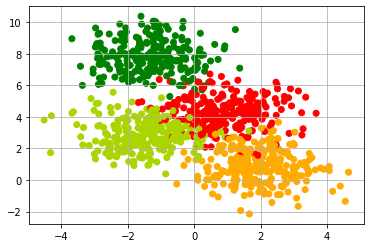

In [16]:
plt.scatter(data[:,0], data[:,1], c = labels, cmap = my_cmap)
plt.grid()
plt.show()

In [17]:
labels_orig = labels
labels = np.mod(labels_orig, 2)

# Splitting to Train and Test

In [18]:
X_train, X_val, Y_train, Y_val = train_test_split(data, labels_orig, stratify=labels_orig, random_state=0)
print(X_train.shape, X_val.shape, Y_train.shape, Y_val.shape, labels_orig.shape)

(750, 2) (250, 2) (750,) (250,) (1000,)


In [19]:
enc = OneHotEncoder()
# 0 -> (1, 0, 0, 0), 1 -> (0, 1, 0, 0), 2 -> (0, 0, 1, 0), 3 -> (0, 0, 0, 1)
y_OH_train = enc.fit_transform(np.expand_dims(Y_train,1)).toarray()
y_OH_val = enc.fit_transform(np.expand_dims(Y_val,1)).toarray()
print(y_OH_train.shape, y_OH_val.shape)

(750, 4) (250, 4)


In [20]:
class GenericFeedForward:

  def __init__(self, n_inputs, n_outputs, hidden_layers = [2]):
    self.nx = n_inputs
    self.ny = n_outputs
    self.nh = len(hidden_layers)
    self.sizes = [self.nx] + hidden_layers + [self.ny]

    self.W = {}
    self.B = {}
    for i in range(self.nh+1):
      self.W[i+1] = np.random.randn(self.sizes[i], self.sizes[i+1])
      self.B[i+1] = np.zeros((1, self.sizes[i+1]))

  def sigmoid(self, X):
    return 1.0 + (1.0 / np.exp(-X))

  def softmax(self, X):
    exps = np.exp(X)
    return exps / np.sum(exps, axis = 1).reshape(-1, 1)

  def forward_pass(self, X):
    self.A = {}
    self.H = {}
    self.H[0] = X
    for i in range(self.nh):
      self.A[i+1] = np.matmul(self.H[i], self.W[i+1]) + self.B[i+1]
      self.H[i+1] = self.sigmoid(self.A[i+1])
    self.A[self.nh+1] = np.matmul(self.H[self.nh], self.W[self.nh+1]) + self.B[self.nh+1]
    self.H[self.nh+1] = self.softmax(self.A[self.nh+1])
    return self.H[self.nh+1]

  def grad_sigmoid(self, X):
    return X * (1 - X)

  def grad(self, X, Y):
    self.forward_pass(X)
    self.dW = {}
    self.dB = {}
    self.dH = {}
    self.dA = {}
    L = self.nh + 1
    self.dA[L] = (self.H[L] - Y)
    for k in range(L, 0, -1):
      self.dW[k] = np.matmul(self.H[k-1].T, self.dA[k])
      self.dB[k] = np.sum(self.dA[k], axis = 0)
      self.dH[k-1] = np.matmul(self.dA[k], self.W[k].T)
      self.dA[k-1] = np.multiply(self.dH[k-1], self.grad_sigmoid(self.H[k-1]))

  def fit(self, X, Y, epochs = 1, lr = 1, initialize = True, display_loss = False):

    if display_loss:
      loss = {}

    if initialize:
      for i in range(self.nh+1):
        self.W[i+1] = np.random.randn(self.sizes[i], self.sizes[i+1])
        self.B[i+1] = np.zeros((1, self.sizes[i+1]))

    for i in tqdm_notebook(range(epochs), total = epochs, unit = "epoch"):
      self.grad(X, Y)
      m = X.shape[0]

      for i in range(self.nh+1):
        self.W[i+1] -= lr*(self.dW[i+1]/m)
        self.B[i+1] -= lr*(self.dB[i+1]/m)


      if display_loss:
        Y_pred = self.predict(X)
        loss[i] = log_loss(np.argmax(Y, axis = 1), Y_pred)

    

    if display_loss:
      plt.plot(np.array(list(loss.values())).astype(float))
      plt.xlabel('Epochs')
      plt.ylabel('Log Loss')
      plt.show()

  def predict(self, X):
    Y_pred = self.forward_pass(X)
    return np.array(Y_pred).squeeze()




In [21]:
generic = GenericFeedForward(2,4,[2])

In [ ]:
generic.fit(X_train, y_OH_train, epochs = 2000, lr = 0.5, display_loss = True)